In [ ]:
# Import all required libraries
import pandas as pd
import numpy as np
import pingouin as pg
from pathlib import Path
from scipy import stats
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import os.path as op
import re
import nibabel as nib

# Additional imports for neuroimaging and atlas processing
from nilearn import datasets, masking, input_data
from nilearn.connectome import ConnectivityMeasure
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_91432/2425085947.py:15: DeprecationWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  from nilearn import datasets, masking, input_data


In [2]:
# Setup directories and plotting theme
RELI_DIR = Path("dset/derivatives/caps/interrater")
FIGURES_DIR = Path("dset/derivatives/figures")
# will use loop later to run over all subjects
OUT_DIR = Path("dset/derivatives/caps")


In [4]:
# Load Craddock atlas from local file
print("Loading Craddock atlas from local file...")

# Path to the unzipped atlas file
atlas_filename = Path("dset/craddock2012_tcorr05_2level_270_2mm.nii")

print(f"Atlas loaded: {atlas_filename}")

# Load the atlas to check its properties
atlas_img = nib.load(atlas_filename)
atlas_data = atlas_img.get_fdata()

# Get unique ROI labels (excluding background/0)
unique_labels = np.unique(atlas_data)
unique_labels = unique_labels[unique_labels != 0]  # Remove background
n_rois = len(unique_labels)

print(f"Atlas shape: {atlas_data.shape}")
print(f"Number of ROIs: {n_rois}")
print(f"ROI labels range: {unique_labels.min()} to {unique_labels.max()}")


Loading Craddock atlas from local file...
Atlas loaded: dset/craddock2012_tcorr05_2level_270_2mm.nii
Atlas shape: (91, 109, 91, 1)
Number of ROIs: 268
ROI labels range: 1.0 to 270.0


In [5]:
# Create masker for extracting time series from ROIs
masker = input_data.NiftiLabelsMasker(
    labels_img=atlas_img,
    standardize=True,  #z-scores the time series
    memory='nilearn_cache',
    verbose=1
)

In [ ]:
# Define all runs for each participant and episode
participant_data = {
    "sub-Blossom": {
        "episode_2": [1, 2, 3, 4, 5, 6, 7]  # Available runs for episode 2
    }
    # Add other participants as needed
}


In [ ]:
# Extract BOLD time series and create z-scored participant matrices

# Initialize storage for participant-level matrices
all_participant_matrices = {}

for sub_id, episodes in participant_data.items():
    print(f"\n{'='*60}")
    print(f"PROCESSING {sub_id}")
    print(f"{'='*60}")
    
    participant_timeseries = []
    
    for episode_key, run_numbers in episodes.items():
        ep_num = int(episode_key.split('_')[1])
        
        print(f"\nProcessing Episode {ep_num} with {len(run_numbers)} runs...")
        
        for run_num in run_numbers:
            print(f"  Processing run {run_num}...")
            
            TASK_DIR = Path(f"dset/{sub_id}/ses-{ep_num:02d}/func") 
            
            # Construct the filename - note that run number is NOT zero-padded
            task_filename = f"{sub_id}_ses-{ep_num:02d}_task-strangerthings_run-{run_num}_part-mag_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
            task_filepath = TASK_DIR / task_filename


            # Extract time series from 268 ROIs
            print(f"    Extracting time series from {task_filepath.name}...")
            time_series = masker.fit_transform(task_filepath)
                
            print(f"    Time series shape: {time_series.shape} (TRs x ROIs)")
                
            # Store z-scored time series for this run
            participant_timeseries.append(time_series)
                

    if participant_timeseries:
        # Concatenate all runs for this participant
        print(f"\nConcatenating {len(participant_timeseries)} runs for {sub_id}...")
        participant_matrix = np.vstack(participant_timeseries)
        
        print(f"Final participant matrix shape: {participant_matrix.shape}")
        print(f"  - Total TRs across all runs: {participant_matrix.shape[0]}")
        print(f"  - Number of ROIs (Craddock): {participant_matrix.shape[1]}")
        
        # Store the participant-level matrix
        all_participant_matrices[sub_id] = participant_matrix
        
        # Save the participant matrix
        output_dir = OUT_DIR / "timeseries_matrices"
        output_dir.mkdir(parents=True, exist_ok=True)
        
        output_file = output_dir / f"{sub_id}_zscore_timeseries_matrix.npy"
        np.save(output_file, participant_matrix)
        print(f"Saved participant matrix to: {output_file}")
        
        # Also save as CSV for easier inspection
        output_csv = output_dir / f"{sub_id}_zscore_timeseries_matrix.csv"
        df_matrix = pd.DataFrame(participant_matrix, 
                                columns=[f"ROI_{i+1:03d}" for i in range(participant_matrix.shape[1])])
        df_matrix.to_csv(output_csv, index=False)
        print(f"Saved participant matrix (CSV) to: {output_csv}")
        


print(f"\n{'='*60}")
print("PROCESSING COMPLETE")
print(f"{'='*60}")
print(f"Processed {len(all_participant_matrices)} participants:")
for sub_id, matrix in all_participant_matrices.items():
    print(f"  {sub_id}: {matrix.shape[0]} TRs × {matrix.shape[1]} ROIs")





PROCESSING sub-Blossom

Processing Episode 2 with 7 runs...
  Processing run 1...
    Extracting time series from sub-Blossom_ses-02_task-strangerthings_run-1_part-mag_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz...
[NiftiLabelsMasker.wrapped] Loading regions from <nibabel.nifti1.Nifti1Image object at 0x11506ef90>
[NiftiLabelsMasker.wrapped] Resampling regions
[NiftiLabelsMasker.wrapped] Resampling regions
[NiftiLabelsMasker.wrapped] Finished fit
[NiftiLabelsMasker.wrapped] Finished fit
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker.filter_and_extract...
filter_and_extract(PosixPath('dset/sub-Blossom/ses-02/func/sub-Blossom_ses-02_task-strangerthings_run-1_part-mag_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz'), 
<nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x118c2da90>, { 'background_label': 0,
  'clean_args': None,
  'clean_kwargs': {},
  'cmap': 'CMRmap_r',
  


LOADING AND CLUSTERING sub-Blossom
Loaded time series matrix: (2121, 268)
  - Time points (TRs): 2121
  - ROIs: 268

Determining optimal number of clusters...
  k=2: Inertia=462083.69, Silhouette=0.152
  k=3: Inertia=425647.62, Silhouette=0.106
  k=4: Inertia=402793.44, Silhouette=0.093
  k=3: Inertia=425647.62, Silhouette=0.106
  k=4: Inertia=402793.44, Silhouette=0.093
  k=5: Inertia=384758.09, Silhouette=0.087
  k=5: Inertia=384758.09, Silhouette=0.087
  k=6: Inertia=373622.22, Silhouette=0.080
  k=7: Inertia=364701.38, Silhouette=0.073
  k=6: Inertia=373622.22, Silhouette=0.080
  k=7: Inertia=364701.38, Silhouette=0.073
  k=8: Inertia=357427.62, Silhouette=0.067
  k=9: Inertia=350835.06, Silhouette=0.065
  k=8: Inertia=357427.62, Silhouette=0.067
  k=9: Inertia=350835.06, Silhouette=0.065
  k=10: Inertia=344894.44, Silhouette=0.063
  k=10: Inertia=344894.44, Silhouette=0.063
  k=11: Inertia=340258.81, Silhouette=0.063
  k=11: Inertia=340258.81, Silhouette=0.063
  k=12: Inertia=335

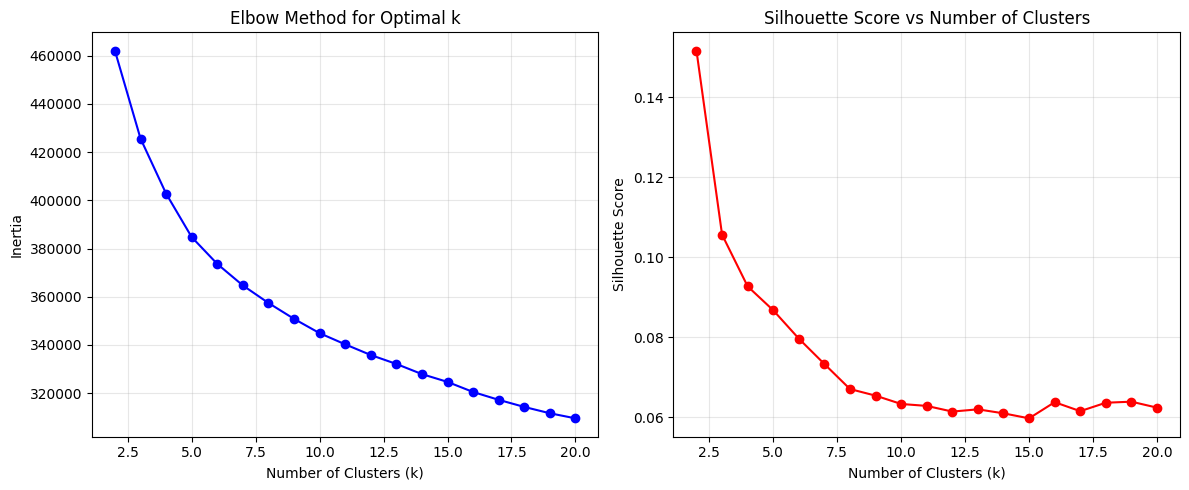


Elbow method results:
  - Optimal number of clusters (elbow): 4
  - Silhouette score at elbow k: 0.093
  - Inertia at elbow k: 402793.44

For comparison:
  - Best silhouette k: 2
  - Best silhouette score: 0.152

Optimal number of clusters: 4
Silhouette score at optimal k: 0.093

Performing final k-means clustering with k=4 (elbow method)...
Clustering results:
  - Total time points: 2121
  - Number of clusters: 4
  - Cluster 0: 255 time points (12.0%)
  - Cluster 1: 539 time points (25.4%)
  - Cluster 2: 519 time points (24.5%)
  - Cluster 3: 808 time points (38.1%)

Saved cluster labels to: dset/derivatives/caps/clustering_results/sub-Blossom_cluster_labels.npy
Saved cluster centers (CAPs) to: dset/derivatives/caps/clustering_results/sub-Blossom_cluster_centers.npy
Saved clustering metadata to: dset/derivatives/caps/clustering_results/sub-Blossom_clustering_metadata.txt

CLUSTERING COMPLETE


In [ ]:
# Load saved time series matrices and perform k-means clustering

for sub_id in participant_data.items():
    print(f"\n{'='*60}")
    print(f"LOADING AND CLUSTERING {sub_id}")
    print(f"{'='*60}")
    
    timeseries_file = OUT_DIR / f"timeseries_matrices/{sub_id}_zscore_timeseries_matrix.npy"
    
    if timeseries_file.exists():
        # Load the participant time series matrix
        participant_matrix = np.load(timeseries_file)
        print(f"Loaded time series matrix: {participant_matrix.shape}")
        print(f"  - Time points (TRs): {participant_matrix.shape[0]}")
        print(f"  - ROIs: {participant_matrix.shape[1]}")
        
        # Determine optimal number of clusters using elbow method and silhouette score
        print("\nDetermining optimal number of clusters...")
        k_range = range(2, 21)  # Test 2 to 20 clusters
        inertias = []
        silhouette_scores = []
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(participant_matrix)
            
            inertias.append(kmeans.inertia_)
            sil_score = silhouette_score(participant_matrix, cluster_labels)
            silhouette_scores.append(sil_score)
            
            print(f"  k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.3f}")
        
        # Plot elbow curve and silhouette scores
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Elbow plot
        ax1.plot(k_range, inertias, 'bo-')
        ax1.set_xlabel('Number of Clusters (k)')
        ax1.set_ylabel('Inertia')
        ax1.set_title('Elbow Method for Optimal k')
        ax1.grid(True, alpha=0.3)
        
        # Silhouette score plot
        ax2.plot(k_range, silhouette_scores, 'ro-')
        ax2.set_xlabel('Number of Clusters (k)')
        ax2.set_ylabel('Silhouette Score')
        ax2.set_title('Silhouette Score vs Number of Clusters')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Find optimal k based on elbow method
        # Calculate the rate of change (differences) in inertia
        inertia_diffs = np.diff(inertias)
        
        # Calculate the second derivative (rate of change of the rate of change)
        second_diffs = np.diff(inertia_diffs)
        
        # Find the elbow point - where the second derivative is maximum
        # (greatest change in the rate of decrease)
        elbow_idx = np.argmax(second_diffs) + 2  # +2 because we lost 2 points in double diff
        optimal_k = k_range[elbow_idx]
        
        # Also report the silhouette score for this k
        corresponding_silhouette = silhouette_scores[elbow_idx]
        
        print(f"\nElbow method results:")
        print(f"  - Optimal number of clusters (elbow): {optimal_k}")
        print(f"  - Silhouette score at elbow k: {corresponding_silhouette:.3f}")
        print(f"  - Inertia at elbow k: {inertias[elbow_idx]:.2f}")
        
        # For comparison, also show the k with best silhouette score
        best_sil_k = k_range[np.argmax(silhouette_scores)]
        max_silhouette = max(silhouette_scores)
        print(f"\nFor comparison:")
        print(f"  - Best silhouette k: {best_sil_k}")
        print(f"  - Best silhouette score: {max_silhouette:.3f}")
        
        print(f"\nOptimal number of clusters: {optimal_k}")
        print(f"Silhouette score at optimal k: {corresponding_silhouette:.3f}")
        
        # Perform final clustering with optimal k (from elbow method)
        print(f"\nPerforming final k-means clustering with k={optimal_k} (elbow method)...")
        final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        final_labels = final_kmeans.fit_predict(participant_matrix)
        
        # Get cluster information
        unique_labels, label_counts = np.unique(final_labels, return_counts=True)
        
        print(f"Clustering results:")
        print(f"  - Total time points: {len(final_labels)}")
        print(f"  - Number of clusters: {len(unique_labels)}")
        
        for i, (label, count) in enumerate(zip(unique_labels, label_counts)):
            percentage = (count / len(final_labels)) * 100
            print(f"  - Cluster {label}: {count} time points ({percentage:.1f}%)")
        
        # Save clustering results
        cluster_output_dir = OUT_DIR / "kmeans"
        cluster_output_dir.mkdir(parents=True, exist_ok=True)
        
        # Save cluster labels
        labels_file = cluster_output_dir / f"{sub_id}_cluster_labels.npy"
        np.save(labels_file, final_labels)
        print(f"\nSaved cluster labels to: {labels_file}")
        
        # Save cluster centers (CAPs)
        centers_file = cluster_output_dir / f"{sub_id}_cluster_centers.npy"
        np.save(centers_file, final_kmeans.cluster_centers_)
        print(f"Saved cluster centers (CAPs) to: {centers_file}")
        
        # Save clustering metadata
        metadata = {
            'n_clusters': optimal_k,
            'method': 'elbow',
            'silhouette_score': corresponding_silhouette,
            'inertia': final_kmeans.inertia_,
            'cluster_sizes': label_counts.tolist(),
            'total_timepoints': len(final_labels),
            'best_silhouette_k': best_sil_k,
            'max_silhouette_score': max_silhouette
        }
        
        metadata_file = cluster_output_dir / f"{sub_id}_clustering_metadata.txt"
        with open(metadata_file, 'w') as f:
            for key, value in metadata.items():
                f.write(f"{key}: {value}\n")
        print(f"Saved clustering metadata to: {metadata_file}")
        
        # Store results for further analysis
        globals()[f"{sub_id}_cluster_labels"] = final_labels
        globals()[f"{sub_id}_cluster_centers"] = final_kmeans.cluster_centers_
        globals()[f"{sub_id}_kmeans_model"] = final_kmeans
        
    else:
        print(f"ERROR: Time series file not found: {timeseries_file}")

print(f"\n{'='*60}")
print("CLUSTERING COMPLETE")
print(f"{'='*60}")

In [10]:
for sub_id in participant_data.items():
    centers_file = OUT_DIR / f"kmeans/{sub_id}_cluster_centers.npy"